In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import jang.utils.conversions
from jang.io import GW, NuDetector, SuperNuDetector, Parameters
from jang.io.neutrinos import BackgroundGaussian, BackgroundFixed, BackgroundPoisson
import jang.analysis.limits as limits

%matplotlib inline

/home/lamoureuxm/anaconda3/envs/env_jang/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Starting remarks
* For the notebook to run, you need to install `jang` as a package (`pip install -e .` from the root directory).
* It is better to keep this code at its current location as there are some relative paths defined here, though you may modify it.

# Setup

## General parameters

In [2]:
parameters = Parameters("input_files/config.yaml")
parameters.set_models("x**-2", jang.utils.conversions.JetIsotropic())

## GW-side definitions

In [3]:
gw = GW(
        "GW190412", 
        "input_files/gw_catalogs/GW190412/GW190412_PublicationSamples.fits", 
        "input_files/gw_catalogs/GW190412/GW190412_subset.h5"
)
gw.set_parameters(parameters)

[2024-05-10 14:35:52,198:jang:INFO] [GW] Fits is loaded from the file GW190412_PublicationSamples.fits
[2024-05-10 14:35:52,199:jang:INFO] [GW] Samples are loaded from the file GW190412_subset.h5


## Neutrino-side definitions

### Detector definitions

ANTARES is defined by the YAML config file `detector_antares.yaml`. It specifies there are four different analysis samples with their names. Similarly, Super-Kamiokande is defined with three analysis samples.


In [4]:
antares = NuDetector("input_files/detector_antares.yaml")
superkamiokande = NuDetector("input_files/detector_superk.yaml")

[2024-05-10 14:35:52,226:jang:INFO] [NuDetector] Object is loaded from the file input_files/detector_antares.yaml.
[2024-05-10 14:35:52,229:jang:INFO] [NuDetector] Object is loaded from the file input_files/detector_superk.yaml.


One can also define its own detector using a `dict` object.

In [5]:
mydetector = NuDetector({
    "name": "MyLittleDetector",
    "nsamples": 1,
    "samples": {
        "names": ["MyLittleSample"],
        "shortnames": ["mls"],
        "energyrange": [0.1, 1e5],
    },
})

[2024-05-10 14:35:52,250:jang:INFO] [NuDetector] Object is loaded from a dictionary object.


### Effective area / acceptance inputs

The detector response should be characterized by the acceptance for a given neutrino spectrum. For instance, assuming a flux $\frac{dN}{dE} = \phi (E/{\rm GeV})^{-\gamma}$ (with $\phi$ in ${\rm GeV}^{-1} {\rm cm}^{-2}$), the corresponding acceptance for $E^{-\gamma}$ spectrum is defined as the ratio between the expected number of signal events for such a flux and $\phi$: 
\begin{equation*}
\textrm{Acceptance} = N_{\rm sig} / \phi
\end{equation*}
It has units of ${\rm GeV} {\rm cm}^2$. When the source direction is not known (as it is the case for GW), this acceptance is usually a function of the source direction $\Omega$:
\begin{equation*}
\textrm{Acceptance}(\Omega) = N_{\rm sig}(\Omega) / \phi
\end{equation*}

Acceptance may be estimated directly from Monte Carlo, but it may also be computed starting from the detector effective area. The effective area is the function that, when convoluted with the neutrino spectrum, gives the expected number of signal events:
\begin{equation*}
N_{\rm sig}(\Omega) = \int_{E_{\min}}^{E_{\max}} A_{\rm eff}(E, \Omega) \times \frac{dN}{dE} dE
\end{equation*}
where the effective area $A_{\rm eff}(E, \Omega)$ is expressed in ${\rm cm}^2$.
So, for an $E^{-\gamma}$ spectrum:
\begin{equation*}
\textrm{Acceptance}(\Omega) = \int_{E_{\min}}^{E_{\max}} A_{\rm eff}(E, \Omega) \times (E/GeV)^{-\gamma} dE
\end{equation*}

For JANG, the acceptance are to be provided as HealPix map with a given resolution `nside`. See [tutorial here](https://healpy.readthedocs.io/en/latest/tutorial.html).

The ANTARES acceptances defined below are rough estimates from [JCAP 04 (2023) 004](https://doi.org/10.1088/1475-7516/2023/04/004). The exact values used in the actual analysis are direction-dependent and GW-dependent (as the analysis cuts are optimized independently for each GW alert).

In [6]:
# defining average acceptances for ANTARES (per half-sky)
nside = 8
ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
alt, az = antares.radec_to_altaz(ra*u.deg, dec*u.deg, gw.jd)
upgoing, downgoing = alt <= 0, alt > 0
# upgoing samples (acc=0 for downgoing sky)
acceptance_antares_uptracks = np.zeros(hp.nside2npix(nside))
acceptance_antares_uptracks[upgoing] = 2
acceptance_antares_upshowers = np.zeros(hp.nside2npix(nside))
acceptance_antares_upshowers[upgoing] = 1
# downoing samples (acc=0 for upgoing sky)
acceptance_antares_downtracks = np.zeros(hp.nside2npix(nside))
acceptance_antares_downtracks[downgoing] = 0.5
acceptance_antares_downshowers = np.zeros(hp.nside2npix(nside))
acceptance_antares_downshowers[downgoing] = 0.4

In [7]:
# defining acceptances from effective area for Super-Kamiokande (effective area class in "superkamiokande" example)
# we estimate it for E^-2 spectrum 
# YOU NEED PYROOT BINDING FOR THIS PART
try:
    from superkamiokande import EffectiveAreaSK
    acceptance_superkamiokande = {}
    for sample in superkamiokande.samples:
        effectivearea = EffectiveAreaSK(filename="input_files/effarea_superk.root", sample=sample)
        acceptance_superkamiokande[sample.shortname] = effectivearea.to_acceptance(superkamiokande, nside, gw.jd, "x**-2")
except ModuleNotFoundError:
    print("ROOT not found, just setting some fake values")   
    acceptance_superkamiokande = {}
    for sample in superkamiokande.samples:
        acceptance_superkamiokande[sample.shortname] = 0.5 * np.ones(hp.nside2npix(nside))

# defining uniform acceptance for MyDetector
acceptance_mydet = np.ones(hp.nside2npix(nside))
    
# filling acceptances to the Detector objects
antares.set_acceptances([acceptance_antares_uptracks, 
                         acceptance_antares_upshowers, 
                         acceptance_antares_downtracks, 
                         acceptance_antares_downshowers],
                        "x**-2", nside=nside)
superkamiokande.set_acceptances([acceptance_superkamiokande[s] for s in ["FC", "PC", "UPMU"]],
                                "x**-2", nside=nside)
mydetector.set_acceptances([acceptance_mydet], "x**-2", nside=nside)

Welcome to JupyROOT 6.30/04


### Observation inputs

The other main ingredients on the neutrino side are the observed and expected number of events in the different samples. The observed number of events is just an integer. The expected one may be provided in different formats that are presented below.

In [8]:
# ANTARES background taken as a Gaussian prior with different mean for each sample and 20% error
bkg_antares = [BackgroundGaussian(b, 0.20 * b) for b in [2.7e-3, 2.7e-3, 2.7e-3, 2.7e-3]]
# ANTARES observed number of events
nobs_antares = [0, 0, 0, 0]

# Super-Kamiokande background taken as a fixed value with no uncertainties
bkg_superkamiokande = [BackgroundFixed(b) for b in [0.112, 0.007, 0.016]]
# Super-Kamiokande observed number of events
nobs_superkamiokande = [0, 0, 0]

# Background from an OFF measurement where alpha_offon is the ratio between the size (time/angular) of OFF and ON regions
bkg_mydet = [BackgroundPoisson(20, alpha_offon=50)]
# Observed number of events
nobs_mydet = [0]

# Filling values to the detector objects
antares.set_observations(nobs_antares, bkg_antares)
superkamiokande.set_observations(nobs_superkamiokande, bkg_superkamiokande)
mydetector.set_observations(nobs_mydet, bkg_mydet)

# Computing the limits per detector

### Compute limits on the flux
As all acceptances were provided for $E^{-2}$, this will be the limit on $\phi$ for $dN/dE = \phi \times (E/GeV)^{-2}$.

In [9]:
limit_flux_antares = limits.get_limit_flux(antares, gw, parameters)
limit_flux_superkamiokande = limits.get_limit_flux(superkamiokande, gw, parameters)
limit_flux_mydet = limits.get_limit_flux(mydetector, gw, parameters)

[2024-05-10 14:44:56,976:jang:INFO] [Limits] GW190412, ANTARES, x**-2, limit(Flux) = 1.518e+01
[2024-05-10 14:44:58,584:jang:INFO] [Limits] GW190412, Super-Kamiokande, x**-2, limit(Flux) = 1.080e+02
[2024-05-10 14:45:00,297:jang:INFO] [Limits] GW190412, MyLittleDetector, x**-2, limit(Flux) = 1.366e+01


We can also skymaps where there is no marginalisation over source direction anymore

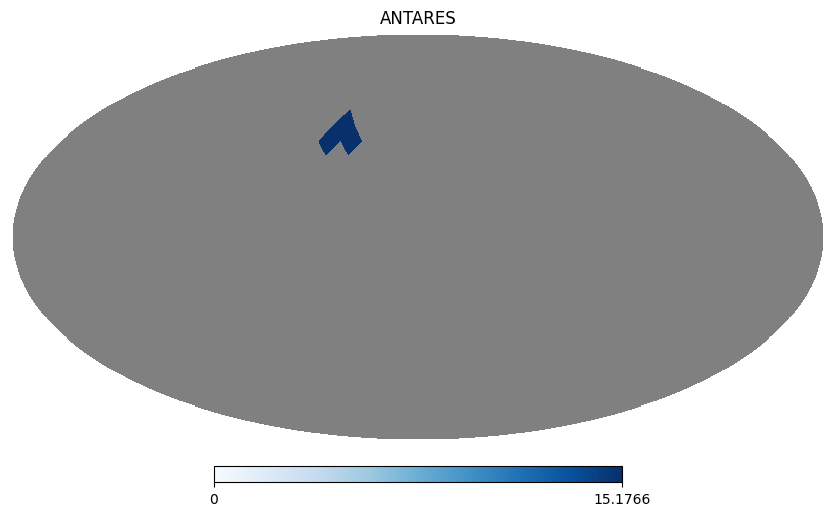

In [10]:
limitmap_flux_antares = limits.get_limitmap_flux(antares, gw, parameters)
hp.mollview(limitmap_flux_antares, rot=180, cmap="Blues", fig=1, title="ANTARES", min=0)

### Compute limits on the total energy emitted in neutrinos

This takes benefit from the source distance provided in the GW h5 file. The default option is to ask for the isotropic energy: $E_{\rm iso} = 4\pi d^2 \int E \times \frac{dn}{dE} dE$. But, changing the parameter object, it is also possible to consider some jetted emission.

In [11]:
# isotropic
limit_eiso_antares = limits.get_limit_etot(antares, gw, parameters)
limit_eiso_superkamiokande = limits.get_limit_etot(superkamiokande, gw, parameters)
limit_eiso_mydet = limits.get_limit_etot(mydetector, gw, parameters)

[2024-05-10 14:45:11,721:jang:INFO] [Limits] GW190412, ANTARES, Isotropic, x**-2, limit(Etot) = 2.951e+55 erg
[2024-05-10 14:45:15,095:jang:INFO] [Limits] GW190412, Super-Kamiokande, Isotropic, x**-2, limit(Etot) = 2.101e+56 erg
[2024-05-10 14:45:16,853:jang:INFO] [Limits] GW190412, MyLittleDetector, Isotropic, x**-2, limit(Etot) = 2.656e+55 erg


In [12]:
# jetted emission with Von Mises model and jet opening = 50 deg (unreasonably large just for the example)
parameters_jetted = Parameters("input_files/config.yaml")
parameters_jetted.set_models("x**-2", jang.utils.conversions.JetVonMises(np.deg2rad(50)))
limit_etotVM_antares = limits.get_limit_etot(antares, gw, parameters_jetted)
limit_etotVM_superkamiokande = limits.get_limit_etot(superkamiokande, gw, parameters_jetted)
limit_etotVM_mydet = limits.get_limit_etot(mydetector, gw, parameters_jetted)

[2024-05-10 14:45:18,745:jang:INFO] [Limits] GW190412, ANTARES, VonMises,50.0 deg, x**-2, limit(Etot) = 1.711e+55 erg
[2024-05-10 14:45:20,532:jang:INFO] [Limits] GW190412, Super-Kamiokande, VonMises,50.0 deg, x**-2, limit(Etot) = 1.221e+56 erg
[2024-05-10 14:45:22,276:jang:INFO] [Limits] GW190412, MyLittleDetector, VonMises,50.0 deg, x**-2, limit(Etot) = 1.540e+55 erg


### Compute limits on the ratio between neutrino and GW energies

This takes benefit from the source distance **and the radiated energy** provided in the GW h5 file. The default option is still with isotropic energy: $f_{\nu} = E_{\rm iso} / E_{\rm GW}$, but other options can be investigated as above.

In [13]:
# isotropic
limit_fnuiso_antares = limits.get_limit_fnu(antares, gw, parameters)
limit_fnuiso_superkamiokande = limits.get_limit_fnu(superkamiokande, gw, parameters)
limit_fnuiso_mydet = limits.get_limit_fnu(mydetector, gw, parameters)

[2024-05-10 14:45:25,885:jang:INFO] [Limits] GW190412, ANTARES, Isotropic, x**-2, limit(fnu) = 1.482e+01
[2024-05-10 14:45:30,223:jang:INFO] [Limits] GW190412, Super-Kamiokande, Isotropic, x**-2, limit(fnu) = 1.055e+02
[2024-05-10 14:45:34,730:jang:INFO] [Limits] GW190412, MyLittleDetector, Isotropic, x**-2, limit(fnu) = 1.334e+01


# Computing the limits combining detectors

In [14]:
# define combined detector
combined_det = SuperNuDetector("ANTARES + Super-Kamiokande")
combined_det.add_detector(antares)
combined_det.add_detector(superkamiokande)

# get upper limit on flux
limit_flux_combined = limits.get_limit_flux(combined_det, gw, parameters)
limit_eiso_combined = limits.get_limit_etot(combined_det, gw, parameters)

[2024-05-10 14:45:34,875:jang:INFO] [SuperDetector] Detector ANTARES is added to the SuperDetector.
[2024-05-10 14:45:34,877:jang:INFO] [SuperDetector] Detector Super-Kamiokande is added to the SuperDetector.
[2024-05-10 14:45:38,725:jang:INFO] [Limits] GW190412, ANTARES + Super-Kamiokande, x**-2, limit(Flux) = 1.331e+01
[2024-05-10 14:45:42,804:jang:INFO] [Limits] GW190412, ANTARES + Super-Kamiokande, Isotropic, x**-2, limit(Etot) = 2.587e+55 erg


In [15]:
# compare with per-detector limits
print(f"Limit with ANTARES -> {limit_flux_antares:.2e} GeV^-1 cm^-2")
print(f"Limit with Super-Kamiokande -> {limit_flux_superkamiokande:.2e} GeV^-1 cm^-2")
print(f"Best of the two -> {min(limit_flux_antares, limit_flux_superkamiokande):.2e} GeV^-1 cm^-2")
#
print(f"Limit with ANTARES+Super-Kamiokande -> {limit_flux_combined:.2e} GeV^-1 cm^-2")
print(f"Relative improvement -> {100*min(limit_flux_antares, limit_flux_superkamiokande)/limit_flux_combined -100:.2f}%")

Limit with ANTARES -> 1.52e+01 GeV^-1 cm^-2
Limit with Super-Kamiokande -> 1.08e+02 GeV^-1 cm^-2
Best of the two -> 1.52e+01 GeV^-1 cm^-2
Limit with ANTARES+Super-Kamiokande -> 1.33e+01 GeV^-1 cm^-2
Relative improvement -> 14.05%


### Redoing the same for E^-3 spectrum

In [16]:
# still dummy acceptances
antares.set_acceptances([0.0010 * np.ones(hp.nside2npix(8)), 
                         0.0005 * np.ones(hp.nside2npix(8)), 
                         0.0003 * np.ones(hp.nside2npix(8)), 
                         0.0002 * np.ones(hp.nside2npix(8))],
                        "x**-3", nside=8)

try:
    from superkamiokande import EffectiveAreaSK
    acceptance_superkamiokande = {}
    for sample in superkamiokande.samples:
        effectivearea = EffectiveAreaSK(filename="input_files/effarea_superk.root", sample=sample)
        acceptance_superkamiokande[sample.shortname] = effectivearea.to_acceptance(superkamiokande, 8, gw.jd, "x**-3")
except ModuleNotFoundError:
    print("ROOT not found, just setting some fake values")   
    acceptance_superkamiokande = {}
    for sample in superkamiokande.samples:
        acceptance_superkamiokande[sample.shortname] = 0.5 * np.ones(hp.nside2npix(8))

superkamiokande.set_acceptances([acceptance_superkamiokande[s] for s in ["FC", "PC", "UPMU"]],
                                "x**-3", nside=8)

In [17]:
parameters_3 = Parameters("input_files/config.yaml")
parameters_3.set_models("x**-3", jang.utils.conversions.JetIsotropic())

limit_flux_antares_3 = limits.get_limit_flux(antares, gw, parameters_3)
limit_flux_superkamiokande_3 = limits.get_limit_flux(superkamiokande, gw, parameters_3)
limit_flux_combined_3 = limits.get_limit_flux(combined_det, gw, parameters_3)
limit_eiso_antares_3 = limits.get_limit_etot(antares, gw, parameters_3)
limit_eiso_superkamiokande_3 = limits.get_limit_etot(superkamiokande, gw, parameters_3)
limit_eiso_combined_3 = limits.get_limit_etot(combined_det, gw, parameters_3)

[2024-05-10 14:49:44,581:jang:INFO] [Limits] GW190412, ANTARES, x**-3, limit(Flux) = 6.829e+03
[2024-05-10 14:49:46,278:jang:INFO] [Limits] GW190412, Super-Kamiokande, x**-3, limit(Flux) = 6.999e+03
[2024-05-10 14:49:48,155:jang:INFO] [Limits] GW190412, ANTARES + Super-Kamiokande, x**-3, limit(Flux) = 3.456e+03
[2024-05-10 14:49:50,346:jang:INFO] [Limits] GW190412, ANTARES, Isotropic, x**-3, limit(Etot) = 1.580e+56 erg
[2024-05-10 14:49:52,489:jang:INFO] [Limits] GW190412, Super-Kamiokande, Isotropic, x**-3, limit(Etot) = 1.619e+56 erg
[2024-05-10 14:49:54,602:jang:INFO] [Limits] GW190412, ANTARES + Super-Kamiokande, Isotropic, x**-3, limit(Etot) = 7.996e+55 erg


In [18]:
# compare with per-detector limits
print(f"Limit with ANTARES -> {limit_flux_antares_3:.2e} GeV^-1 cm^-2")
print(f"Limit with Super-Kamiokande -> {limit_flux_superkamiokande_3:.2e} GeV^-1 cm^-2")
print(f"Best of the two -> {min(limit_flux_antares_3, limit_flux_superkamiokande_3):.2e} GeV^-1 cm^-2")
#
print(f"Limit with ANTARES+Super-Kamiokande -> {limit_flux_combined_3:.2e} GeV^-1 cm^-2")
print(f"Relative improvement -> {100*min(limit_flux_antares_3, limit_flux_superkamiokande_3)/limit_flux_combined_3 -100:.2f}%")

Limit with ANTARES -> 6.83e+03 GeV^-1 cm^-2
Limit with Super-Kamiokande -> 7.00e+03 GeV^-1 cm^-2
Best of the two -> 6.83e+03 GeV^-1 cm^-2
Limit with ANTARES+Super-Kamiokande -> 3.46e+03 GeV^-1 cm^-2
Relative improvement -> 97.61%


### Making some final plot

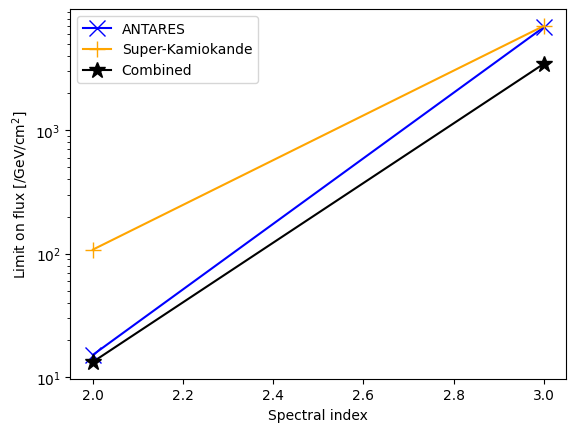

In [19]:
plt.plot([2,3], [limit_flux_antares, limit_flux_antares_3], color="blue", label="ANTARES", marker="x", markersize=12)
plt.plot([2,3], [limit_flux_superkamiokande, limit_flux_superkamiokande_3], color="orange", label="Super-Kamiokande", marker="+", markersize=12)
plt.plot([2,3], [limit_flux_combined, limit_flux_combined_3], color="black", label="Combined", marker="*", markersize=12)
plt.xlabel("Spectral index")
plt.ylabel(r"Limit on flux [/GeV/cm$^{2}$]")
plt.yscale("log")
plt.legend(loc="best")

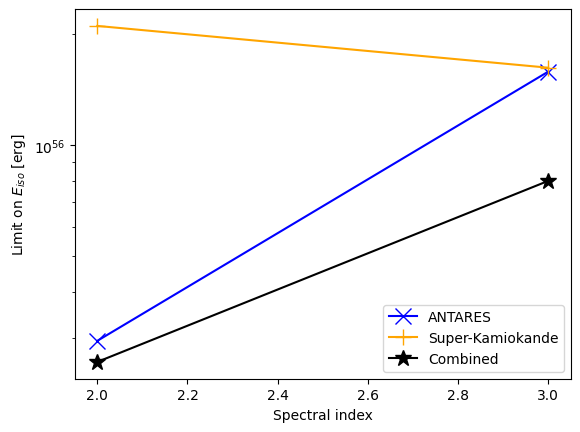

In [20]:
plt.plot([2,3], [limit_eiso_antares, limit_eiso_antares_3], color="blue", label="ANTARES", marker="x", markersize=12)
plt.plot([2,3], [limit_eiso_superkamiokande, limit_eiso_superkamiokande_3], color="orange", label="Super-Kamiokande", marker="+", markersize=12)
plt.plot([2,3], [limit_eiso_combined, limit_eiso_combined_3], color="black", label="Combined", marker="*", markersize=12)
plt.xlabel("Spectral index")
plt.ylabel(r"Limit on $E_{iso}$ [erg]")
plt.yscale("log")
plt.legend(loc="best")